In [19]:
from random import seed 
from random import randrange
from math import sqrt
import numpy as np
import pandas as pd

In [31]:
def n_split(dataset, n_folds):
    dataset_split = list()
    dataset_copy = list(dataset)
    fold_size = int(len(dataset) / n_folds)
    for i in range(n_folds):
        fold = list()
        while len(fold) < fold_size:
            index = randrange(len(dataset_copy))
            fold.append(dataset_copy.pop(index))
        dataset_split.append(fold)
    print('Samples are splitted successfully')
    return dataset_split


def test_split(index, value, dataset):
    left, right = list(), list()
    for row in dataset:
        if row[index] < value:
            left.append(row)
        else:
            right.append(row)
    return left, right
 
def accuracy_score(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0
 
def fit(dataset, sample_size, rfc, *args):
    print('Algorithm starts to work................')
    folds = n_split(dataset, n_samples)
    accuracies = list()
    #for each subsample
    for fold in folds:
        train_set = list(folds)
        train_set = sum(train_set, [])
        test_set = list()
        #add each row in a given subsample to the test set
        for row in fold:
            row_copy = list(row)
            test_set.append(row_copy)
            row_copy[-1] = None
        
        
        print("Let's get the labels")
        predicted = random_forest(train_set, test_set, sample_size, rfc, *args)
        actual = [row[-1] for row in fold]
        accuracy = accuracy_score(actual, predicted)
        accuracies.append(accuracy)
        
    return accuracies

# Counting Gini index
def gini_index(groups, class_values):
    gini = 0.0
    for class_value in class_values:
        for group in groups:
            size = len(group)
            if size == 0:
                continue
            proportion = [row[-1] for row in group].count(class_value) / float(size)
            gini += (proportion * (1.0 - proportion))
    return gini
 

def get_split(dataset, n_features):
    class_values = list(set(row[-1] for row in dataset))
    b_index, b_value, b_score, b_groups = 10000, 10000, 10000, None # just huge numbers
    features = list()
    while len(features) < n_features:
        index = randrange(len(dataset[0])-1)
        if index not in features:
            features.append(index)
            
    for index in features:
        for row in dataset:
            groups = test_split(index, row[index], dataset)
            gini = gini_index(groups, class_values)
            if gini < b_score:
                b_index, b_value, b_score, b_groups = index, row[index], gini, groups

    return {'index':b_index, 'value':b_value, 'groups':b_groups}
 

def to_leaf(group): 
    classes_count = [row[-1] for row in group]
    #returns the most common output value in a list of rows.
    return max(set(classes_count), key=classes_count.count)

def split(node, max_depth, min_size, n_features, depth):
    left, right = node['groups']
    del(node['groups'])
    
    if not left or not right:
        node['left'] = node['right'] = to_leaf(left + right)
        return

    if depth >= max_depth:
        node['left'], node['right'] = to_leaf(left), to_leaf(right)
        return

    if len(left) <= min_size:
        node['left'] = to_leaf(left)
    else:
        node['left'] = get_split(left, n_features)
        split(node['left'], max_depth, min_size, n_features, depth+1)

    if len(right) <= min_size:
        node['right'] = to_leaf(right)
    else:
        node['right'] = get_split(right, n_features)
        split(node['right'], max_depth, min_size, n_features, depth+1)
        

#Building the tree
def build_tree(train, max_depth, min_size, n_features):
    print "Starting to build another tree"
    root = get_split(train, n_features)
    split(root, max_depth, min_size, n_features, 1)
    return root
 
# Make a prediction with a decision tree
def predict(node, row):
    if row[node['index']] < node['value']:
        if isinstance(node['left'], dict):
            return predict(node['left'], row)
        else:
            return node['left']
    else:
        if isinstance(node['right'], dict):
            return predict(node['right'], row)
        else:
            return node['right']

        
def subsample(dataset, proportion):
    sample = list()
    n_sample = round(len(dataset) * proportion)
    while len(sample) < n_sample:
        index = randrange(len(dataset))
        sample.append(dataset[index])
    return sample

def bagging_predict(trees, row):
    predictions = [predict(tree, row) for tree in trees]
    return max(set(predictions), key=predictions.count)
 
def random_forest(train, test, sample_size, rfc, *args):
    trees = list()
    for i in range(rfc.n_trees):
        sample = subsample(train, sample_size)
        tree = build_tree(sample, rfc.max_depth, rfc.min_size, rfc.n_features)
        trees.append(tree)
    print "Forest is created"
    predictions = [bagging_predict(trees, row) for row in test]
    return(predictions)

In [21]:
class RandomForestClassificator:
    def __init__(self, n_trees, min_size, n_samples, max_depth, n_features):
        self.n_trees = n_trees
        self.min_size = min_size
        self.max_depth = max_depth
        self.n_features = n_features
        self.n_samples = n_samples

In [22]:
dataset = pd.read_csv('learn.csv')
dataframe = dataset[(dataset.answer == 1) | (dataset.answer == 7)]
df = dataframe.sample(n=10000)
df = df.as_matrix()[:10000, :785]
print df

[[0 0 0 ..., 0 0 7]
 [0 0 0 ..., 0 0 1]
 [0 0 0 ..., 0 0 7]
 ..., 
 [0 0 0 ..., 0 0 7]
 [0 0 0 ..., 0 0 7]
 [0 0 0 ..., 0 0 1]]


In [24]:
n_samples = 2
max_depth = 4
min_size = 1
sample_size = 0.1
n_features = int(sqrt(len(df[0])-1))
trees = np.arange(1, 11, 2)
accuracies = []
for n_trees in trees:
    rfc = RandomForestClassificator(n_trees, min_size, n_samples, max_depth, n_features)
    scores = fit(df, sample_size, rfc)
    print('Number of trees: %d' % n_trees)
    print('Scores on our samples: %s' % scores)
    print('Mean accuracy of our RFC algorithm: %.4f%%' % (sum(scores)/float(len(scores))))
    accuracies.append((sum(scores)/float(len(scores))))
    print('--------------------------------------------------------')

Algorithm starts to work................
Samples are splitted successfully
Let's get the labels
Starting to build another tree
Forest is created
Let's get the labels
Starting to build another tree
Forest is created
Number of trees: 1
Scores on our samples: [92.17999999999999, 89.1]
Mean accuracy of our RFC algorithm: 90.6400%
--------------------------------------------------------
Algorithm starts to work................
Samples are splitted successfully
Let's get the labels
Starting to build another tree
Starting to build another tree
Starting to build another tree
Forest is created
Let's get the labels
Starting to build another tree
Starting to build another tree
Starting to build another tree
Forest is created
Number of trees: 3
Scores on our samples: [95.32000000000001, 96.66]
Mean accuracy of our RFC algorithm: 95.9900%
--------------------------------------------------------
Algorithm starts to work................
Samples are splitted successfully
Let's get the labels
Starting 

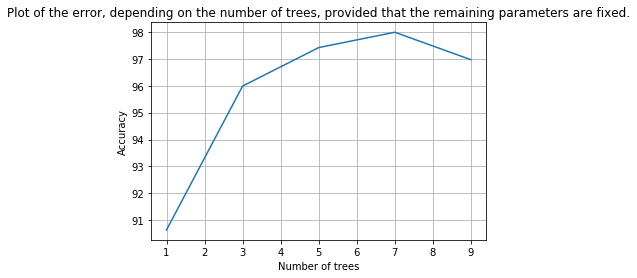

In [25]:
import matplotlib.pyplot as plt

t = np.arange(1, 11, 2)
plt.plot(t, accuracies)

plt.xlabel('Number of trees')
plt.ylabel('Accuracy')
plt.title('Plot of the error, depending on the number of trees, provided that the remaining parameters are fixed.')
plt.grid(True)
plt.show()

In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

digits = df[:10000, :784]
tags = df[:, 784]
# Splitting into train and test
x_train, x_test, y_train, y_test = train_test_split(digits, tags, test_size=0.25)

clf = RandomForestClassifier()
clf.fit(x_train, y_train)

print round(accuracy_score(y_test, clf.predict(x_test)) * 100, 2)
print round(accuracy_score(y_train, clf.predict(x_train)) * 100, 2)
print(clf.predict(x_test[1][:785].reshape(1,-1)))
print y_test[1]

99.44
99.97
[1]
1
